In [1]:
import pandas as pd 
import numpy as np  
from sklearn.datasets import fetch_20newsgroups 
import re
from sklearn.decomposition import PCA

In [2]:
# Selected 3 categories from the 20 newsgroups dataset
categories = [
    'talk.religion.misc',
    'comp.graphics',
    'sci.space',
]
    
print("Loading 20 newsgroups dataset for categories:")
print(categories)

Loading 20 newsgroups dataset for categories:
['talk.religion.misc', 'comp.graphics', 'sci.space']


In [3]:
# subset > all : to retrieve all the data training and testing 
# remove = ('headers', 'footers', 'quotes') : to focus only on the text 
def collect_data():
    dataset = fetch_20newsgroups(subset='all', 
                    shuffle=False, remove=('headers', 'footers', 'quotes'),categories=categories)    
    df = pd.DataFrame()
    df["data"] = dataset["data"]
    df["target"] = dataset["target"]
    df["target_names"] = df.target.apply(lambda row: dataset["target_names"][row])
    return df

In [4]:
df = collect_data()

In [5]:
def clean_text(df, text_column):
    """
    Cleans the text in a specified column of a DataFrame.
    Args:
        df (pd.DataFrame): The input DataFrame.
        text_column (str): The name of the column containing text data.

    Returns:
        pd.DataFrame: The DataFrame with cleaned text.
    """
    df[text_column] = df[text_column].astype(str).str.lower()  
    df[text_column] = df[text_column].apply(lambda text: re.sub(r'[^a-z\s]', '', text))  # Keep only letters and spaces
    df[text_column] = df[text_column].apply(lambda text: re.sub(r'\s+', ' ', text).strip())  # Remove extra spaces
    return df

In [6]:
df = clean_text(df,'data')
df

,data,target,target_names
0,i think i can largely as a result of efforts b...,1,sci.space
1,in regards to fractal commpression i have seen...,0,comp.graphics
2,background the orion spacedrive was a theoreti...,1,sci.space
3,do what thou wilt shall be the whole of the la...,2,talk.religion.misc
4,,1,sci.space
...,...,...,...
2583,i get regular questions about gamma correction...,0,comp.graphics
2584,when robert refers to the orthodox he is talki...,2,talk.religion.misc
2585,hello there a week ago a guy asked what a sco ...,0,comp.graphics
2586,ive been playing with a program called piclab ...,0,comp.graphics


In [7]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

def tokenize_clean_lemmatize(df, text_column):
    """
    Tokenizes text, removes stopwords, and applies lemmatization.
    
    Args:
        df (pd.DataFrame): The input DataFrame.
        text_column (str): The column containing text data.

    Returns:
        pd.DataFrame: A DataFrame with processed text.
    """
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    def process_sentence(text):
        # Tokenization
        tokens = word_tokenize(text)
        # Removing stopwords & applying lemmatization
        cleaned_tokens = [lemmatizer.lemmatize(word,pos='v') for word in tokens if word.lower() not in stop_words]
        return " ".join(cleaned_tokens)

    df[text_column] = df[text_column].astype(str).apply(process_sentence)
    return df

In [8]:
df = tokenize_clean_lemmatize(df,'data')
df

,data,target,target_names
0,think largely result efforts people read group...,1,sci.space
1,regard fractal commpression see fractal compre...,0,comp.graphics
2,background orion spacedrive theoretical concep...,1,sci.space
3,thou wilt shall whole law honestly word sin re...,2,talk.religion.misc
4,,1,sci.space
...,...,...,...
2583,get regular question gamma correction since go...,0,comp.graphics
2584,robert refer orthodox talk historical position...,2,talk.religion.misc
2585,hello week ago guy ask sco file well research ...,0,comp.graphics
2586,ive play program call piclab modify gif file p...,0,comp.graphics


In [9]:
df = df[df['data'].str.strip().astype(bool)]
df.reset_index(drop=True, inplace=True)
df

,data,target,target_names
0,think largely result efforts people read group...,1,sci.space
1,regard fractal commpression see fractal compre...,0,comp.graphics
2,background orion spacedrive theoretical concep...,1,sci.space
3,thou wilt shall whole law honestly word sin re...,2,talk.religion.misc
4,kudos mark generous offer already exist large ...,1,sci.space
...,...,...,...
2507,get regular question gamma correction since go...,0,comp.graphics
2508,robert refer orthodox talk historical position...,2,talk.religion.misc
2509,hello week ago guy ask sco file well research ...,0,comp.graphics
2510,ive play program call piclab modify gif file p...,0,comp.graphics


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

def compute_tfidf_from_df(df, text_column="text", max_features=500, min_df=4, max_df=0.85, ngram_range=(1,3)):
    """
    Applies optimized TF-IDF vectorization to text in a Pandas DataFrame.

    Args:
        df (pd.DataFrame): DataFrame containing the text data.
        text_column (str): Column name containing text.
        max_features (int): Max number of words to keep.
        min_df (int): Minimum document frequency.
        max_df (float): Maximum document frequency.
        ngram_range (tuple): (min_n, max_n) range for n-grams.

    Returns:
        tfidf_matrix (sparse matrix): TF-IDF transformed feature matrix.
        vectorizer (TfidfVectorizer): The fitted TF-IDF vectorizer.
    """
    vectorizer = TfidfVectorizer(
        max_features=max_features, 
        min_df=min_df, 
        max_df=max_df, 
        ngram_range=ngram_range, 
        stop_words="english"
    )
    tfidf_matrix = vectorizer.fit_transform(df[text_column])  
    return tfidf_matrix, vectorizer


In [11]:
# Apply to dataset
tfidf_matrix, tfidf_vectorizer = compute_tfidf_from_df(df,'data')

In [25]:
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd

def apply_pca(features, n_components):
    """
    Applies PCA to reduce dimensionality of the dataset.

    Parameters:
    - features (np.ndarray): The high-dimensional feature matrix >> takes it Dense Not sparse.
    - n_components (int): Number of PCA components (default: 2).

    Returns:
    - pca_result (np.ndarray): Transformed feature representation.
    """
    pca = PCA(n_components=n_components,svd_solver='auto')
    pca_result = pca.fit_transform(features)
    return pca_result

In [ ]:
pca_result = apply_pca(tfidf_matrix.toarray(), n_components=0.9)    

In [ ]:
pca_result.shape

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def visualize_pca(pca_result, labels=None, n_components=2):
    """Visualizes PCA results in 2D or 3D with hue (color coding)."""
    
    df_pca = pd.DataFrame(pca_result[:, :n_components], columns=[f"PC{i+1}" for i in range(n_components)])
    
    if labels is not None:
        df_pca["Cluster"] = labels
    
    plt.figure(figsize=(10, 6))

    if n_components == 2:
        sns.scatterplot(x="PC1", y="PC2", hue="Cluster" if labels is not None else None, 
                        data=df_pca, palette="tab10", alpha=0.7)
        plt.xlabel("PC1")
        plt.ylabel("PC2")

    elif n_components == 3:
        from mpl_toolkits.mplot3d import Axes3D
        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(df_pca["PC1"], df_pca["PC2"], df_pca["PC3"], 
                             c=labels if labels is not None else "blue", cmap="tab10", alpha=0.7)
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")
        ax.set_zlabel("PC3")

        # Add a legend
        if labels is not None:
            legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
            ax.add_artist(legend1)

    plt.title(f"PCA Visualization ({n_components}D)")
    plt.show()


In [ ]:
visualize_pca(pca_result,labels=df['target'], n_components=2)

In [ ]:
def apply_kmeans(features, n_clusters: int = 3, random_state: int = 42):
    """
    Applies K-Means clustering to the given feature matrix.

    Parameters:
    - features (np.ndarray): Feature matrix (e.g., TF-IDF, Word2Vec).
    - n_clusters (int): Number of clusters to form (default: 5).
    - random_state (int): Random seed for reproducibility (default: 42).

    Returns:
    - labels (np.ndarray): Cluster labels for each data point.
    - kmeans_model (KMeans): Trained KMeans model.
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10)
    labels = kmeans.fit_predict(features)
    return labels, kmeans

In [ ]:
from sklearn.cluster import AgglomerativeClustering

def apply_agglomerative_clustering(features: np.ndarray, n_clusters: int = 3, linkage: str = "ward"):
    """
    Applies Agglomerative Hierarchical Clustering.

    Parameters:
    - features (np.ndarray): Feature matrix.
    - n_clusters (int): Number of clusters to form (default: 5).
    - linkage (str): Linkage criterion ('ward', 'complete', 'average', 'single').

    Returns:
    - labels (np.ndarray): Cluster labels.
    - model (AgglomerativeClustering): Trained clustering model.
    """
    model = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
    labels = model.fit_predict(features)
    return labels, model

In [ ]:
labels , algo = apply_agglomerative_clustering(pca_result, n_clusters=3, linkage='ward') 

In [ ]:
from sklearn.cluster import KMeans
labels , kmeans = apply_kmeans(pca_result, n_clusters=3,random_state=42)

In [ ]:
visualize_pca(pca_result,labels=labels, n_components=2)

In [ ]:
from sklearn.metrics import silhouette_score

def get_silhouette_score(features, labels):
    """
    Computes the silhouette score for clustering.

    Parameters:
    - features (np.ndarray): The feature matrix (e.g., TF-IDF, Word2Vec, etc.).
    - labels (np.ndarray): Cluster labels assigned by the clustering algorithm.

    Returns:
    - float: The silhouette score (higher is better, range: -1 to 1).
    """
    return silhouette_score(features, labels)

In [ ]:
silhouette_score = get_silhouette_score(pca_result,labels)

In [ ]:
print(silhouette_score)

In [ ]:
from sklearn.metrics.cluster import contingency_matrix

# get the purity of each cluster
def purity_score(labels_true, labels_pred):
    """
    Calculates the purity score for evaluating clustering performance.
    
    """
    # Compute contingency matrix (confusion matrix)
    matrix = contingency_matrix(labels_true, labels_pred)
    # Calculate the purity score
    purity = np.sum(np.amax(matrix, axis=0)) / np.sum(matrix)
    return purity

In [ ]:
purity_score = purity_score(df['target'],labels)
print(purity_score)

In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import os
import scipy.sparse as sp


def doc2vec_vectorization(df: pd.DataFrame, text_column: str, model_path="models/doc2vec_news.model",
                          vector_size=100, window=5, min_count=2, epochs=20, return_sparse=True):
    """
    Applies Doc2Vec vectorization to text data.

    Parameters:
    
    - df (pd.DataFrame): Input DataFrame.
    - text_column (str): Column name containing text data.
    - model_path (str): Path to save/load the trained model.
    - vector_size (int): Dimensionality of the document vectors.
    - window (int): Maximum distance between current and predicted word.
    - min_count (int): Ignores words with total frequency lower than this.
    - epochs (int): Number of training iterations.
    - return_sparse (bool): If True, returns a sparse matrix.

    Returns:
    - doc_vectors (np.ndarray or scipy.sparse.csr_matrix): Document vectors.
    - model (Doc2Vec): Trained Doc2Vec model.
    """
    texts = df[text_column].astype(str).tolist()
    tagged_data = [TaggedDocument(words=text.split(), tags=[str(i)]) for i, text in enumerate(texts)]

    if os.path.exists(model_path):
        print(f"🔹 Loading existing Doc2Vec model from {model_path}")
        model = Doc2Vec.load(model_path)
    else:
        print("🚀 Training new Doc2Vec model...")
        model = Doc2Vec(tagged_data, vector_size=vector_size, window=window, min_count=min_count, epochs=epochs)
        model.save(model_path)

    doc_vectors = np.array([model.dv[i] for i in range(len(texts))])

    if return_sparse:
        doc_vectors = sp.csr_matrix(doc_vectors)  # Convert to sparse format

    return doc_vectors, model


In [ ]:
doc2vev_matrix, doc2vec_model = doc2vec_vectorization(df, 'data', model_path="../models/doc2vec_news.model")

In [ ]:
# applying pca
pca_result = apply_pca(doc2vev_matrix.toarray(), n_components=0.9)

In [ ]:
from sklearn.cluster import KMeans
labels , kmeans = apply_kmeans(pca_result, n_clusters=3, random_state=42)

In [ ]:
labels,algo = apply_agglomerative_clustering(pca_result, n_clusters=3, linkage='ward')

In [ ]:

visualize_pca(pca_result, labels=df['target'], n_components=2)
visualize_pca(pca_result, labels=labels, n_components=2)

In [ ]:
shore = get_silhouette_score(pca_result,labels)
purity = purity_score(df['target'],labels)
print(shore)
print(purity)

In [20]:
# argmax
from numpy import argmax

def apply_lda_from_matrix(tfidf_matrix, n_topics=3):
    """
    Applies Latent Dirichlet Allocation (LDA) for topic modeling on a precomputed matrix.

    Parameters:
    - tfidf_matrix (sparse matrix): Precomputed TF-IDF or count matrix.
    - n_topics (int): Number of topics to extract.

    Returns:
    - topic_distributions (np.ndarray): Document-topic matrix.
    - lda_model (LatentDirichletAllocation): Trained LDA model.
    - feature_names (list or None): Vocabulary terms (if vectorizer provided).
    """
    from sklearn.decomposition import LatentDirichletAllocation

    # Apply LDA
    lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    topic_distributions = lda_model.fit_transform(tfidf_matrix)
    labels = argmax(topic_distributions, axis=1)

    return labels, lda_model


In [ ]:
# apply lda
labels, lda_model= apply_lda_from_matrix(tfidf_matrix, n_topics=3)

In [27]:
tfidf_matrix

<2512x500 sparse matrix of type '<class 'numpy.float64'>'
	with 55972 stored elements in Compressed Sparse Row format>

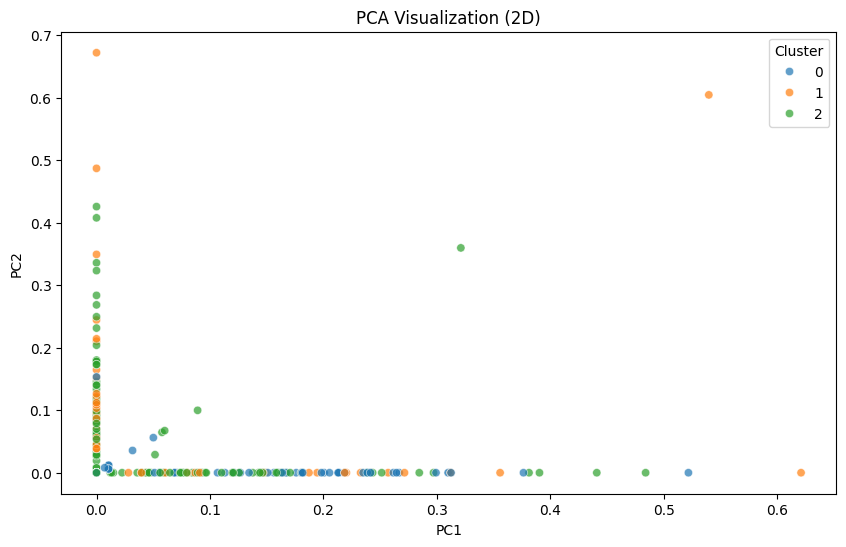

In [28]:
visualize_pca(tfidf_matrix.toarray(), labels=labels, n_components=2)

In [34]:
# apply kmeans
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(topic_distributions)
labels = kmeans.labels_

In [35]:
# get silhouette score
silhouette_score = silhouette_score(topic_distributions, labels)
print("Silhouette Score:", silhouette_score)

Silhouette Score: 0.6746647383818244


In [36]:
# get purity score
purity_score = purity_score(df['target'], labels)
print("Purity Score:", purity_score)

Purity Score: 0.6246019108280255
